In [1]:
import keras
from keras.layers import Dense, Conv2D, Conv2DTranspose, Lambda, Input, Flatten, Reshape, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model
from keras.losses import binary_crossentropy, kl_divergence
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.data import AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import array_to_img
from keras.callbacks import TensorBoard
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


# Plotting sample images

In [4]:
def plot_sample():
    indexes = np.random.randint(0, len(X_train), size=10)
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(8, 4))
    axes = axes.flatten()

    for i, index in enumerate(indexes):
        axes[i].imshow(X_train[index], cmap="gray")
        axes[i].set(title=f"{labels[y_train[index]]}")
        # axes[i].tick_params(axis='both', which='both', bottom=False, left=False)
        axes[i].axis("off")
    fig.suptitle("Plot of sample images.")
    plt.show()

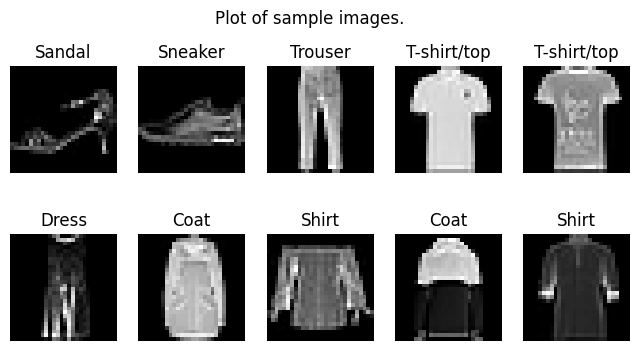

In [5]:
labels = {0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
}

plot_sample()

In [6]:
train_data = np.concatenate((X_train, X_test))
target = np.concatenate((y_train, y_test))

train_data = train_data.reshape((-1, 28, 28, 1))

train_ds = tf.data.Dataset.from_tensor_slices(train_data)
batch_size = 128
train_ds = train_ds.map(lambda x: x/255).batch(batch_size).prefetch(AUTOTUNE)
train_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Sampling

In [7]:
@tf.function
def sampling(inputs):
    mean, log_var = inputs
    eps = K.random_normal(shape=tf.shape(mean))
    z = mean + K.exp(0.5*log_var) * eps
    return z

# Building the Encoder

In [8]:
latent_dim = 2

encoder_input = Input(shape=(28, 28, 1), dtype=tf.float32, batch_size=batch_size)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = Conv2D(128, kernel_size=(2, 2), strides=2, padding="same", activation="relu")(x)
x = Flatten()(x)
x = Dense(64)(x)
mean = Dense(latent_dim, name="mean")(x)
log_var = Dense(latent_dim, name="log_var")(x)
z = Lambda(function=sampling, name="z")([mean, log_var])

encoder = Model(inputs=encoder_input, outputs=[mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(128, 28, 28, 1)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (128, 14, 14, 64)            640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (128, 7, 7, 128)             32896     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (128, 6272)                  0         ['conv2d_1[0][0]']            
                                                                                            

# Building the Decoder

In [9]:
decoder_input = Input(shape=(latent_dim, ), dtype=tf.float32, name="decoder_input", batch_size=batch_size)
x = Dense(7*7*128, activation="relu")(decoder_input)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(128, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, kernel_size=(3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = Conv2DTranspose(1, kernel_size=(3, 3), activation="sigmoid", padding="same")(x)

decoder = Model(inputs=decoder_input, outputs=decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(128, 2)]                0         
                                                                 
 dense_1 (Dense)             (128, 6272)               18816     
                                                                 
 reshape (Reshape)           (128, 7, 7, 128)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (128, 14, 14, 128)        147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (128, 28, 28, 64)         73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (128, 28, 28, 1)          577 

# Putting all of them together.

In [10]:
class VariationalAutoEncoder(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean("total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean("reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean("kl_loss")

    @property
    def metric(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        mean, log_var, z = self.encoder(inputs)
        output = self.decoder(z)
        return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [11]:
vae_model = VariationalAutoEncoder(encoder, decoder)
vae_model.build(input_shape=(None, 28, 28, 1))
vae_model.summary()

Model: "variational_auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(128, 2),                435268    
                              (128, 2),                          
                              (128, 2)]                          
                                                                 
 decoder (Functional)        (128, 28, 28, 1)          240769    
                                                                 
Total params: 676043 (2.58 MB)
Trainable params: 676037 (2.58 MB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [12]:
optimizer = keras.optimizers.Adam()
vae_model.compile(optimizer=optimizer)
vae_model.fit(train_ds, epochs=30)

Epoch 1/30
547/547 [==============================] - 11s 11ms/step - loss: 338.8705 - reconstruction_loss: 294.1093 - kl_loss: 5.4137
Epoch 2/30
547/547 [==============================] - 6s 11ms/step - loss: 271.2779 - reconstruction_loss: 264.7787 - kl_loss: 5.9228
Epoch 3/30
547/547 [==============================] - 6s 11ms/step - loss: 267.7236 - reconstruction_loss: 261.9473 - kl_loss: 5.9957
Epoch 4/30
547/547 [==============================] - 6s 11ms/step - loss: 266.0434 - reconstruction_loss: 260.2846 - kl_loss: 6.0594
Epoch 5/30
547/547 [==============================] - 6s 11ms/step - loss: 264.7780 - reconstruction_loss: 259.1953 - kl_loss: 6.0915
Epoch 6/30
547/547 [==============================] - 6s 11ms/step - loss: 264.0908 - reconstruction_loss: 258.3819 - kl_loss: 6.1366
Epoch 7/30
547/547 [==============================] - 6s 11ms/step - loss: 263.4052 - reconstruction_loss: 257.6855 - kl_loss: 6.1484
Epoch 8/30
547/547 [==============================] - 6s 11ms

# Visualizing the latent space

In [13]:
mean, *_ = vae_model.encoder.predict(train_ds)

547/547 [==============================] - 1s 2ms/step


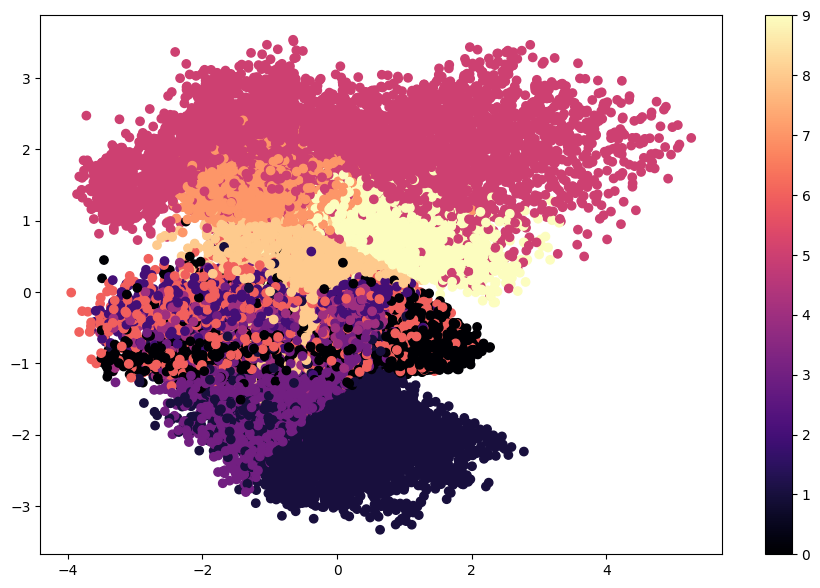

In [14]:
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=target, cmap="magma")
plt.colorbar()
plt.show()

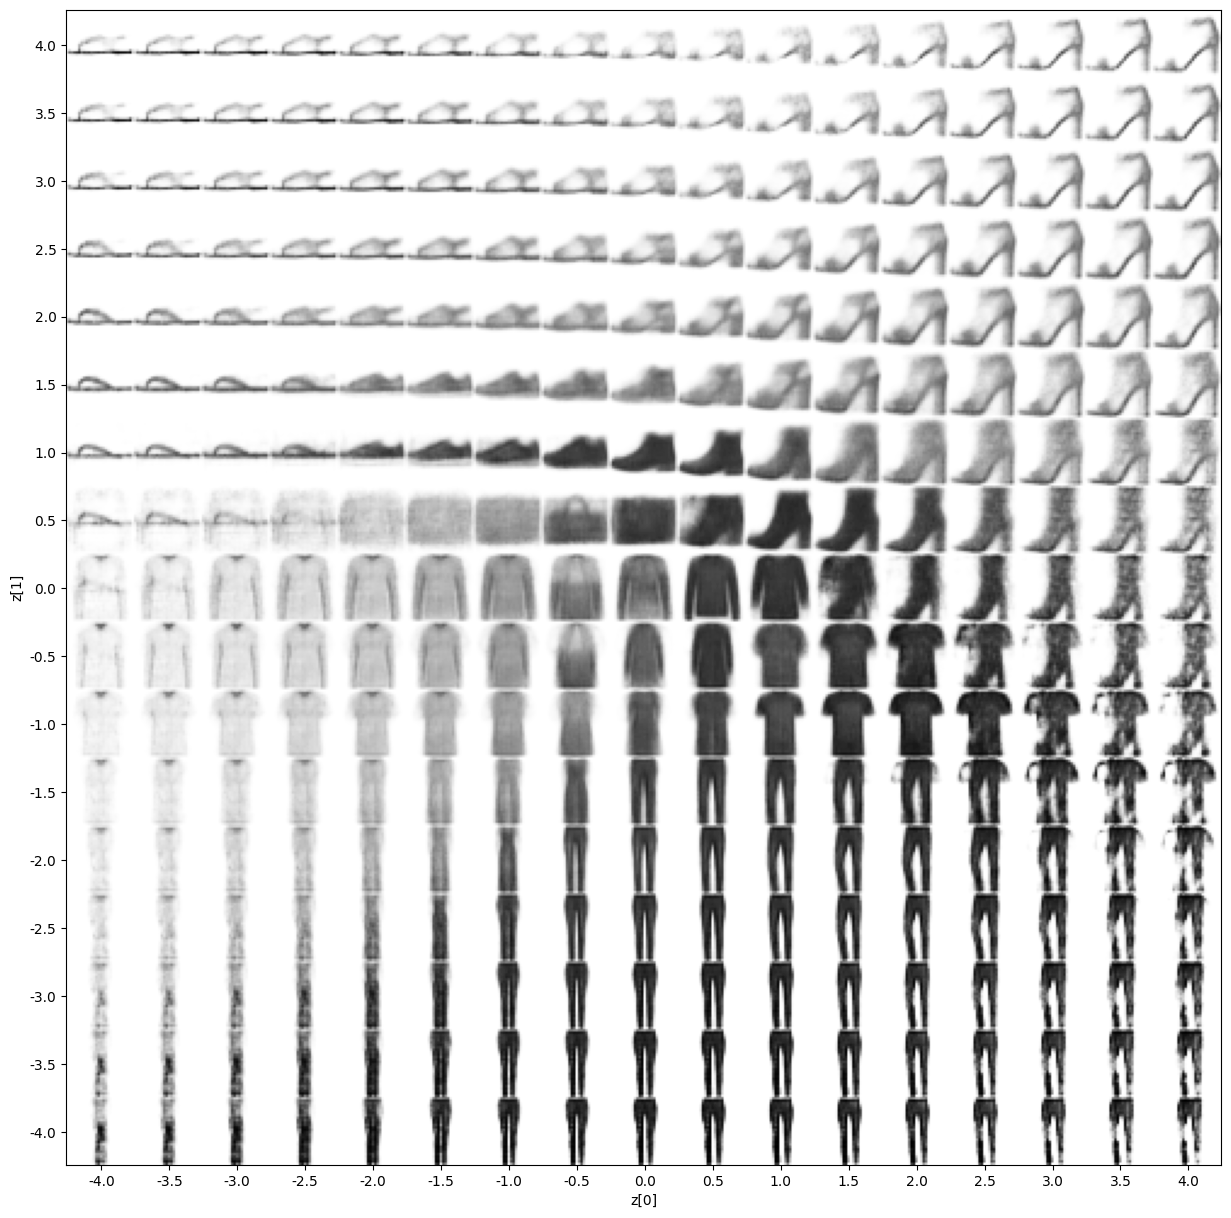

In [15]:
def plot_latent_space(vae, n=17, figsize=15):

    image_size = 28
    scale = 4.0
    figure = np.zeros((image_size * n, image_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(image_size, image_size)
            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = image_size // 2
    end_range = n * image_size + start_range
    pixel_range = np.arange(start_range, end_range, image_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray_r")
    plt.show()


plot_latent_space(vae_model)

# Generating sample images

1/1 [==============================] - 0s 17ms/step


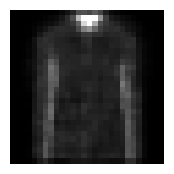

In [16]:
def generate_images(vector):
    decoded = vae_model.decoder.predict(vector)
    decoded = np.squeeze(decoded, axis=0)

    fig = plt.figure(figsize=(3,2))
    plt.imshow(decoded, cmap="gray")
    plt.axis("off")

vector = np.array([[-3.5, -0.5]])
generate_images(vector)